1. Import Data and descriptive statistics
2. Data Preparation and RFM-Model
3. K-Means (including Silhouette Coefficient)
4. DBSCAN with Gower Distance (didn't work but code is still included)
5. DBSCAN 
6. PCA
7. Visualisation

# Import Data & some descriptive statistics

In [ ]:
#import data
import pandas as pd
cust_trans = pd.read_csv("customer_transactions.csv")
trans_jan = pd.read_csv("transactions_january.csv")

cust_trans

In [ ]:
stats = cust_trans.describe(include='all')
print (stats)

In [ ]:
trans_jan

In [ ]:
trans_jan.groupby('transactiontype').count()

In [ ]:
trans_jan.groupby('subcategory').count()

In [ ]:
trans_jan.groupby('category').count()

In [ ]:
stats = trans_jan.describe(include='all')
print (stats)

# Data Preparation & RFM

## Get only needed columns

In [8]:
new_trans_jan = trans_jan[['category','transactiontype','amount','transactiondate','userid']]

In [ ]:
new_trans_jan

## Drop empty rows and rows with category '-'

In [ ]:
new_trans_jan.dropna(subset=['category', 'transactiondate', 'amount'])

In [11]:
new_trans_jan = new_trans_jan[new_trans_jan.category != '-']

In [ ]:
new_trans_jan

In [13]:
new_trans_jan['transactiontype'].unique()

array(['income', 'transfers', 'expenses', 'contributions'], dtype=object)

In [ ]:
## Delete transactiontypes transfers and contributions:

# Get indexes where name column
indexNames1 = new_trans_jan[new_trans_jan['transactiontype'] == 'transfers'].index
# Delete these row indexes from dataFrame
new_trans_jan.drop(indexNames1 , inplace=True)

indexNames2 = new_trans_jan[new_trans_jan['transactiontype'] == 'contributions'].index
# Delete these row indexes from dataFrame

new_trans_jan.drop(indexNames2 , inplace=True)

In [ ]:
new_trans_jan

# RFM

## Calculate Frequency

In [ ]:
#get frequency per user
basic_exp = new_trans_jan.loc[new_trans_jan['category'] == 'basic']
basic_exp['freq_basic_exp'] = basic_exp['category'].groupby(basic_exp['userid']).transform('count')

disc_exp = new_trans_jan.loc[new_trans_jan['category'] == 'discretionary']
disc_exp['freq_disc_exp'] = disc_exp['category'].groupby(disc_exp['userid']).transform('count')

lux_exp = new_trans_jan.loc[new_trans_jan['category'] == 'luxury']
lux_exp['freq_lux_exp'] = lux_exp['category'].groupby(lux_exp['userid']).transform('count')

rec_inc = new_trans_jan.loc[new_trans_jan['transactiontype'] == 'income']
rec_inc['freq_rec_inc'] = rec_inc['category'].groupby(rec_inc['userid']).transform('count')

exp = new_trans_jan.loc[new_trans_jan['transactiontype'] == 'expenses']
exp['freq_exp'] = exp['category'].groupby(exp['userid']).transform('count')



## Get Recency

In [17]:
def get_recency(current_day, dataframe, v_name):
        
    dataframe['transactiondate'] = dataframe['transactiondate'].astype("|S")
    dataframe['transactiondate'] = dataframe['transactiondate'].str[8:10]
    dataframe['date'] = current_day
    dataframe['date'] = dataframe['date'].astype("|I")
    dataframe['transactiondate'] = dataframe['transactiondate'].astype("|I")

    dataframe['days'] = dataframe['date'] - dataframe['transactiondate']
    
    name = 'rec_'+v_name
    dataframe[name] = dataframe.groupby(['userid'])['days'].transform(min)

    return dataframe

In [ ]:
basic_exp = get_recency('31', basic_exp, 'basic_exp')
disc_exp = get_recency('31', disc_exp, 'disc_exp')
lux_exp = get_recency('31', lux_exp, 'lux_exp')

rec_inc = get_recency('31', rec_inc, 'rec_inc')
exp = get_recency('31', exp, 'exp')


## Monetary Value

In [ ]:
#get frequency per user
basic_exp['mon_basic_exp'] = basic_exp['amount'].groupby(basic_exp['userid']).transform('sum')

disc_exp['mon_disc_exp'] = disc_exp['amount'].groupby(disc_exp['userid']).transform('sum')

lux_exp['mon_lux_exp'] = lux_exp['amount'].groupby(lux_exp['userid']).transform('sum')

rec_inc['mon_rec_inc'] = rec_inc['amount'].groupby(rec_inc['userid']).transform('sum')

exp['mon_exp'] = exp['amount'].groupby(exp['userid']).transform('sum')


## Drop duplicate rows & not needed columns

In [20]:
basic_exp = basic_exp.drop(columns=['date', 'days','transactiondate','category', 'transactiontype', 'amount'])
disc_exp = disc_exp.drop(columns=['date', 'days','transactiondate','category', 'transactiontype', 'amount'])
lux_exp = lux_exp.drop(columns=['date', 'days','transactiondate','category', 'transactiontype', 'amount'])

rec_inc = rec_inc.drop(columns=['date', 'days','transactiondate','category', 'transactiontype', 'amount'])
exp = exp.drop(columns=['date', 'days','transactiondate','category', 'transactiontype', 'amount'])


basic_exp = basic_exp.drop_duplicates(keep='first')
disc_exp = disc_exp.drop_duplicates(keep='first')
lux_exp = lux_exp.drop_duplicates(keep='first')

rec_inc = rec_inc.drop_duplicates(keep='first')
exp = exp.drop_duplicates(keep='first')


In [ ]:
basic_exp

## Merge all dataframes

In [22]:
# Get only columns that are needed:
customer_trans = cust_trans[cust_trans['startdate'] == '2017-01-01 00:00:00.000000']
custom_trans = customer_trans[['userid', 'savingcapacity','startdate']].copy()

customers = cust_trans.copy()
customers['startdate'] = customers['startdate'].astype("|S")
customers['startyear'] = customers['startdate'].str[0:4]
customers['startmonth'] = customers['startdate'].str[5:7]
    
customers['month'] = customers['startmonth'].astype("|I")
customers['year'] = customers['startyear'].astype("|I")

customer_trans2 = customers[customers['month'] == 1]
customer_trans2 = customer_trans2[customer_trans2['year'] == 2017]


In [ ]:
customer_trans2

In [ ]:
# Check for duplicate values
customer_trans2['userid'].value_counts()

In [ ]:
#show duplicate user ids
customer_trans2[customer_trans2['userid'].isin(['example-userid1', 'example-userid2'])]

In [26]:
#Drop the duplicate rows (example row numbers used)
customer_trans2 = customer_trans2.drop([1 , 2])

In [ ]:
customer_trans2

In [28]:
transactions = customer_trans2[['userid', 'savingcapacity', 'totalincome']].copy()

In [29]:
## Check if user have savings
def savings(row):
    return row['savingcapacity'] > 0

transactions['savings'] = transactions.apply(lambda row: savings(row), axis=1)

In [ ]:
transactions

In [ ]:
transactions.groupby('savings').count()

In [32]:
transactions = transactions.set_index('userid').join(basic_exp.set_index('userid'), how='left') 
transactions = transactions.reset_index()

transactions = transactions.set_index('userid').join(disc_exp.set_index('userid'), how='left') 
transactions = transactions.reset_index()

In [ ]:
transactions

In [34]:
transactions = transactions.set_index('userid').join(lux_exp.set_index('userid'), how='left') 
transactions = transactions.reset_index()
transactions = transactions.set_index('userid').join(rec_inc.set_index('userid'), how='left') 
transactions = transactions.reset_index()
transactions = transactions.set_index('userid').join(exp.set_index('userid'), how='left') 
transactions = transactions.reset_index()


In [ ]:
transactions

# Data Preprocessing 

In [ ]:
transactions

In [ ]:
stats = transactions.describe(include='all')
print (stats)

In [ ]:
## Count Missing Values
transactions.isnull().sum()

In [39]:
## Delete userid with no expenses:
transactions = transactions.dropna(subset=['freq_exp'])



In [ ]:
## Count Missing Values
transactions.isnull().sum()

In [41]:
## Delete userid with no income:
transactions = transactions.dropna(subset=['freq_rec_inc'])


In [ ]:
transactions

In [43]:
## Fill NaN with 0
transactions['freq_basic_exp'] = transactions['freq_basic_exp'].fillna(0)
transactions['rec_basic_exp'] = transactions['rec_basic_exp'].fillna(30)
transactions['mon_basic_exp'] = transactions['mon_basic_exp'].fillna(0)

transactions['freq_disc_exp'] = transactions['freq_disc_exp'].fillna(0)
transactions['rec_disc_exp'] = transactions['rec_disc_exp'].fillna(30)
transactions['mon_disc_exp'] = transactions['mon_disc_exp'].fillna(0)

transactions['freq_lux_exp'] = transactions['freq_lux_exp'].fillna(0)
transactions['rec_lux_exp'] = transactions['rec_lux_exp'].fillna(30)
transactions['mon_lux_exp'] = transactions['mon_lux_exp'].fillna(0)



In [ ]:
stats = transactions.describe(include='all')
print (stats)

In [ ]:
## What's the median
transactions.median()

In [46]:
## Imports for Correlation Heatmap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
## Correlation Heatmap
transactions.corr()

In [ ]:
sns.heatmap(transactions.corr());

In [ ]:
transactions

## Get ratio for RFM

In [50]:
#assigne group/label for recency
def assign_r_value(dataframe, col_name):
    dataframe[col_name] = dataframe[col_name].astype(int)
    dataframe['extra'] = 'Empty'
    mask = (dataframe[col_name] <= 5)
    dataframe['extra'][mask] = 4

    mask = (dataframe[col_name] >= 6) & (dataframe[col_name] <= 11)
    dataframe['extra'][mask] = 3

    mask = (dataframe[col_name] >= 12) & (dataframe[col_name] <= 17)
    dataframe['extra'][mask] = 2

    mask = (dataframe[col_name] >= 18) & (dataframe[col_name] <= 23)
    dataframe['extra'][mask] = 1

    mask = (dataframe[col_name] >= 24) & (dataframe[col_name] <= 30)
    dataframe['extra'][mask] = 0

    dataframe[col_name] = dataframe['extra']
    dataframe = dataframe.drop(columns=['extra'])
    
    return dataframe

In [ ]:
disc_exp.rec_disc_exp.unique()

In [52]:
transactions_ratio = transactions.copy()

In [ ]:
#min and max values:
transactions_ratio.min()

In [ ]:
#min and max values:
transactions_ratio.max()

In [ ]:
transactions_ratio = assign_r_value(transactions_ratio, 'rec_basic_exp')
transactions_ratio  = assign_r_value(transactions_ratio, 'rec_disc_exp')
transactions_ratio  = assign_r_value(transactions_ratio, 'rec_lux_exp')

transactions_ratio  = assign_r_value(transactions_ratio, 'rec_rec_inc')
transactions_ratio  = assign_r_value(transactions_ratio, 'rec_exp')


In [ ]:
transactions_ratio

### Frequency

In [57]:
def get_thresholds(var, df):
    results, bin_edges = pd.qcut(df[var], 5,
                            labels=False,
                            retbins=True, duplicates='drop')

    results_table = pd.DataFrame(zip(bin_edges, [0,1,2,3,4]),
                            columns=['Threshold', 'Tier'])
    return results_table




In [ ]:

print('freq_basic_exp', get_thresholds('freq_basic_exp', transactions_ratio))
transactions_ratio['freq_basic_exp']= pd.qcut(transactions_ratio['freq_basic_exp'], 5, labels=False, duplicates='drop')

print('freq_disc_exp', get_thresholds('freq_disc_exp', transactions_ratio))
transactions_ratio['freq_disc_exp']= pd.qcut(transactions_ratio['freq_disc_exp'], 5, labels=False, duplicates='drop')

print('freq_lux_exp', get_thresholds('freq_lux_exp', transactions_ratio))
transactions_ratio['freq_lux_exp']= pd.qcut(transactions_ratio['freq_lux_exp'], 5,  labels=False, duplicates='drop')

print('freq_rec_inc', get_thresholds('freq_rec_inc', transactions_ratio))
transactions_ratio['freq_rec_inc']= pd.qcut(transactions_ratio['freq_rec_inc'], 5, labels=False, duplicates='drop')

print('freq_exp', get_thresholds('freq_exp', transactions_ratio))
transactions_ratio['freq_exp']= pd.qcut(transactions_ratio['freq_exp'], 5, labels=False, duplicates='drop')




### Monetary Value

In [ ]:
print('mon_basic_exp', get_thresholds('mon_basic_exp', transactions_ratio))
transactions_ratio['mon_basic_exp']= pd.qcut(transactions_ratio['mon_basic_exp'], 5, labels = False, duplicates='drop')

print('mon_disc_exp', get_thresholds('mon_disc_exp', transactions_ratio))
transactions_ratio['mon_disc_exp']= pd.qcut(transactions_ratio['mon_disc_exp'], 5, labels = False, duplicates='drop')

print('mon_lux_exp', get_thresholds('mon_lux_exp', transactions_ratio))
transactions_ratio['mon_lux_exp']= pd.qcut(transactions_ratio['mon_lux_exp'], 5, labels = False, duplicates='drop')

print('mon_rec_inc', get_thresholds('mon_rec_inc', transactions_ratio))
transactions_ratio['mon_rec_inc']= pd.qcut(transactions_ratio['mon_rec_inc'], 5, labels = False, duplicates='drop')

print('mon_exp', get_thresholds('mon_exp', transactions_ratio))
transactions_ratio['mon_exp']= pd.qcut(transactions_ratio['mon_exp'], 5, labels = False, duplicates='drop')


# Descriptive Statistics for RFM + General

In [ ]:
stats = transactions_ratio.describe(include='all')
print (stats)

In [61]:
tr_ratio_ds = transactions_ratio.copy()

# Get best & worst label customer for RFM

In [62]:
best_exp_inc = tr_ratio_ds.loc[(tr_ratio_ds['freq_exp'] == 4) & (tr_ratio_ds['rec_exp'] == 4) & (tr_ratio_ds['mon_exp'] == 4)
                              &(tr_ratio_ds['freq_rec_inc'] == 4) & (tr_ratio_ds['rec_rec_inc'] == 4) & (tr_ratio_ds['mon_rec_inc'] == 4)                              ]

In [ ]:
best_exp_inc

In [ ]:
stats = best_exp_inc.describe(include='all')
print (stats)

In [65]:
worst_exp_inc = tr_ratio_ds.loc[(tr_ratio_ds['freq_exp'] == 0) & (tr_ratio_ds['rec_exp'] == 0) & (tr_ratio_ds['mon_exp'] == 0)
                              &(tr_ratio_ds['freq_rec_inc'] == 0) & (tr_ratio_ds['rec_rec_inc'] == 0) & (tr_ratio_ds['mon_rec_inc'] == 0)                              ]

In [ ]:
worst_exp_inc

In [ ]:
stats = worst_exp_inc.describe(include='all')
print (stats)

# K-Means

## Elbow Criteria

In [ ]:
transactions

In [69]:
from sklearn.preprocessing import StandardScaler

In [70]:
rfm_exp = transactions.copy()
rfm_exp = rfm_exp.drop(columns=['userid','totalincome', 'savings', 'savingcapacity','freq_rec_inc', 'rec_rec_inc', 'mon_rec_inc', 'freq_exp', 'rec_exp', 'mon_exp'])



In [71]:
#take out outliers
from scipy import stats
rfm_no_exp_3 = rfm_exp[(np.abs(stats.zscore(rfm_exp)) < 3).all(axis=1)]


In [72]:
rfm_no_exp_2 = rfm_exp[(np.abs(stats.zscore(rfm_exp)) < 2).all(axis=1)]


In [73]:
#number of outliers:
print("3", len(rfm_exp)-len(rfm_no_exp_3))
print("2", len(rfm_exp)-len(rfm_no_exp_2))

3 7369
2 17909


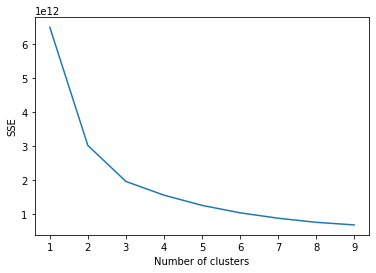

CPU times: user 25.9 s, sys: 3.7 s, total: 29.6 s
Wall time: 8.23 s


In [73]:
%%time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=20).fit(rfm_no_exp_3)
    
    # Inertia is the distance of each observation to its closest centroid
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

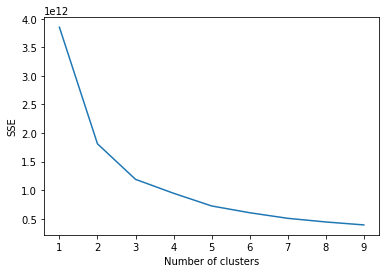

CPU times: user 24.8 s, sys: 3.21 s, total: 28 s
Wall time: 7.23 s


In [74]:
%%time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=20).fit(rfm_no_exp_2)
    
    # Inertia is the distance of each observation to its closest centroid
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [75]:
#Standardisationa
rfm_all_exp_3 = StandardScaler().fit_transform(rfm_no_exp_3)
rfm_all_exp_2 = StandardScaler().fit_transform(rfm_no_exp_2)

# Silhouette Coefficient

For n_clusters = 2 The average silhouette_score is : 0.32685846963083653
For n_clusters = 3 The average silhouette_score is : 0.3154342281336952
For n_clusters = 4 The average silhouette_score is : 0.3294070324756001
For n_clusters = 5 The average silhouette_score is : 0.24399068967290616


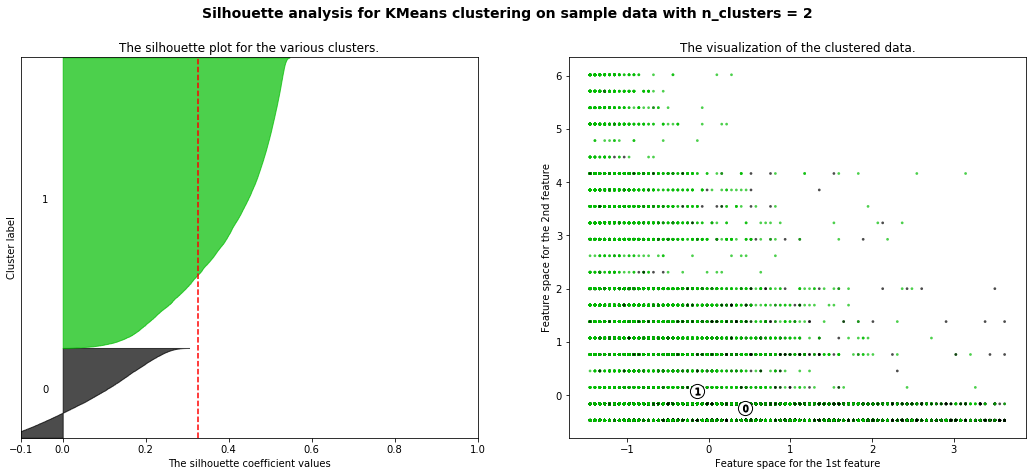

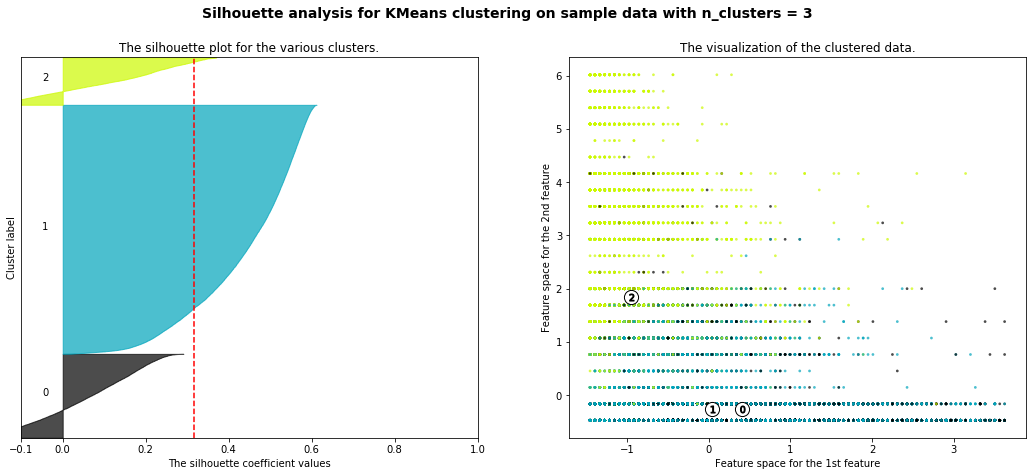

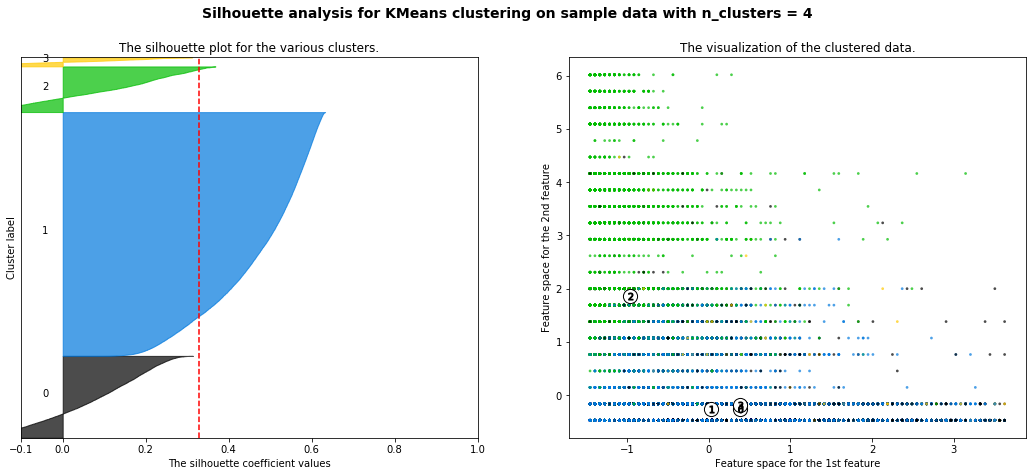

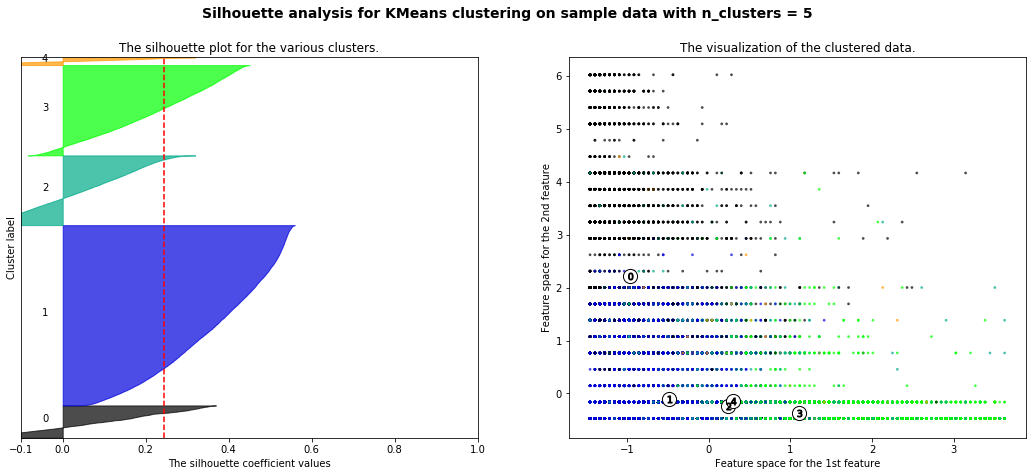

CPU times: user 11min 21s, sys: 3min 18s, total: 14min 40s
Wall time: 8min 20s


In [76]:
%%time
#rfm_all_exp_3
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(rfm_all_exp_3) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(rfm_all_exp_3)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(rfm_all_exp_3, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_all_exp_3, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(rfm_all_exp_3[:, 0], rfm_all_exp_3[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


For n_clusters = 2 The average silhouette_score is : 0.33786242048712956
For n_clusters = 3 The average silhouette_score is : 0.3105621087950614
For n_clusters = 4 The average silhouette_score is : 0.2121985991121461
For n_clusters = 5 The average silhouette_score is : 0.23368729115542727


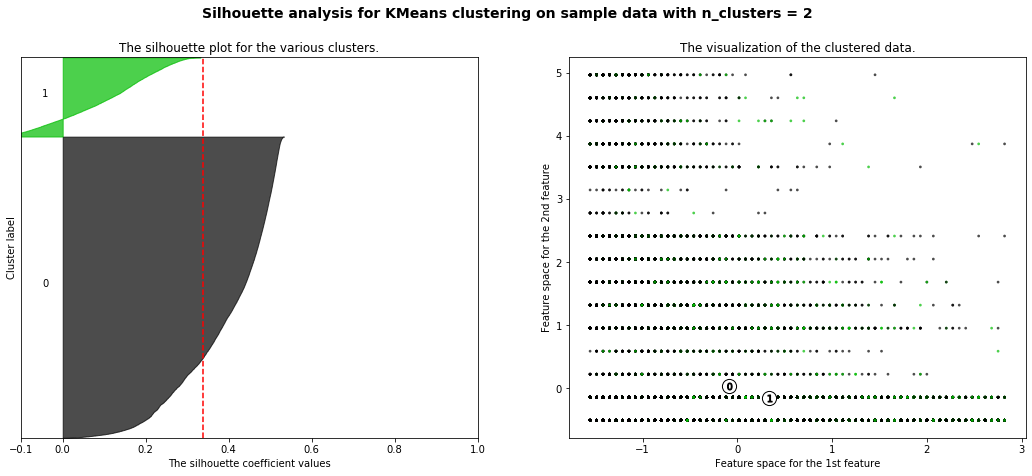

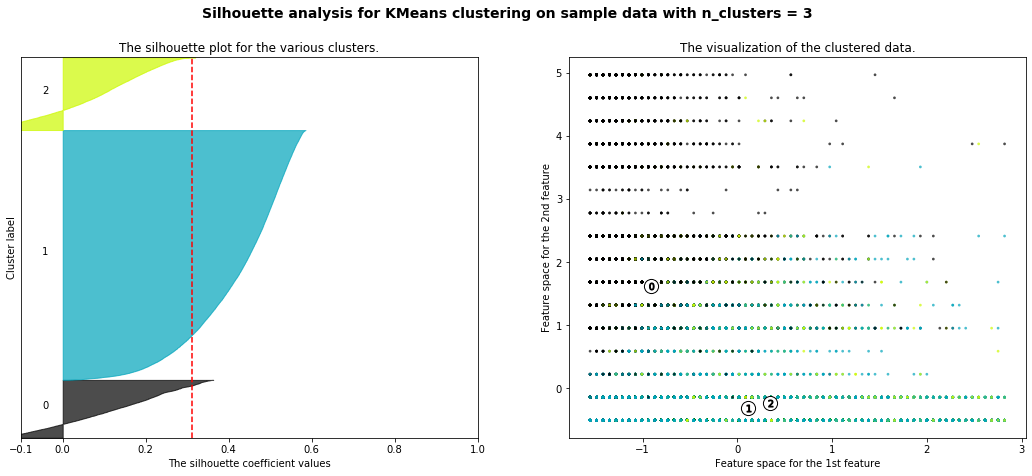

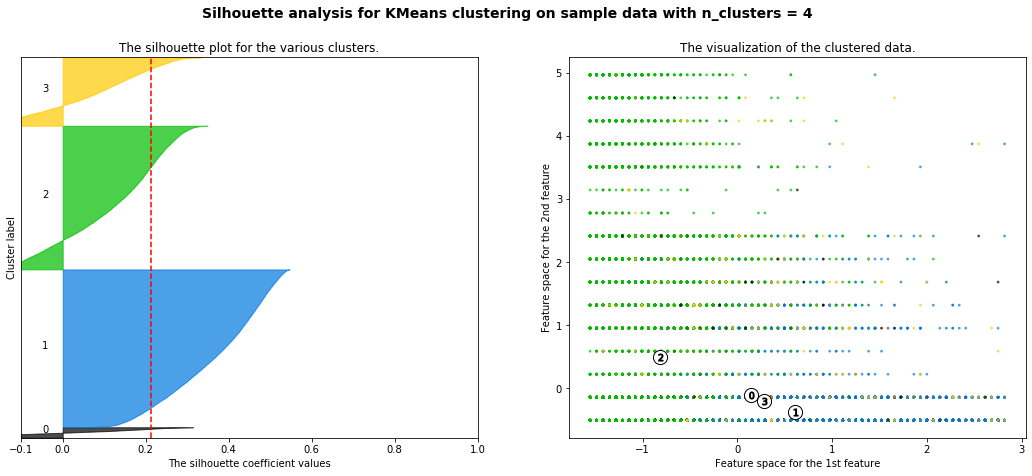

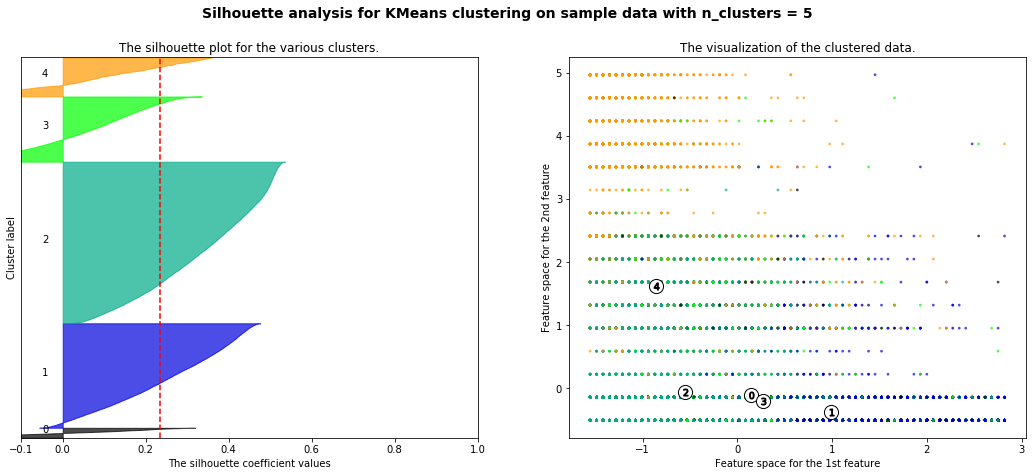

CPU times: user 8min 14s, sys: 2min 20s, total: 10min 34s
Wall time: 5min 56s


In [77]:
%%time
#rfm_all_exp_2
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(rfm_all_exp_2) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(rfm_all_exp_2)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(rfm_all_exp_2, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_all_exp_2, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(rfm_all_exp_2[:, 0], rfm_all_exp_2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


# Final K-Means with k number chosen

In [119]:
#take out outliers
from scipy import stats
data = rfm_exp[(np.abs(stats.zscore(rfm_exp)) < 2).all(axis=1)]



In [ ]:
data

In [121]:
from sklearn.preprocessing import StandardScaler

In [ ]:
data_to_standardize = data.copy()
standardized_columns = StandardScaler().fit_transform(data_to_standardize)

standardized_data = standardized_columns

# It's helpful to double check that the final data looks good.
print('Sample of data to use:')
print(standardized_data)
print('')


# Step 5: Fit the model.
# ~~~~~~~~~~~~~~~~~~~~~~

model = KMeans(n_clusters=3).fit(standardized_data)


# Step 6: Get the results.
# ~~~~~~~~~~~~~~~~~~~~~~~~

# It's helpful to see the results on the unstandardized data.
# The output of model.predict() is an integer representing
# the cluster that each data point is classified with.
data['cluster'] = model.predict(standardized_data)

# It's helpful to take a quick look at the count and
# average value values per cluster.

print('Cluster summary:')
summary = data.groupby(['cluster']).mean()
summary['count'] = data['cluster'].value_counts()
summary = summary.sort_values(by='count', ascending=False)
print(summary)

print('Cluster Min summary:')
min_summary = data.groupby(['cluster']).min()
min_summary['count'] = data['cluster'].value_counts()
min_summary = min_summary.sort_values(by='count', ascending=False)
print(min_summary)

print('Cluster Max summary:')
max_summary = data.groupby(['cluster']).max()
max_summary['count'] = data['cluster'].value_counts()
max_summary = max_summary.sort_values(by='count', ascending=False)
print(max_summary)

In [ ]:
data

### DBSCAN with Gower Distance as an example, but it did not work properly

In [ ]:
# pip install gower

In [ ]:
# import gower
# %%time
# distance_matrix = gower.gower_matrix(over_and_med.head(10000))

In [ ]:
# %%time
# from sklearn.cluster import DBSCAN
# import numpy as np
# from sklearn import metrics


# # Configuring the parameters of the clustering algorithm
# dbscan_cluster = DBSCAN(eps=0.3, 
#                         min_samples=2, 
#                         metric="precomputed")

# # Fitting the clustering algorithm
# dbscan_cluster.fit(distance_matrix)

# # Adding the results to a new column in the dataframe

# labels = dbscan_cluster.labels_


# labels



# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(distance_matrix, dbscan_cluster.labels_))

# DBSCAN without Gower Distance without Labels

In [124]:
# transactions
rfm_exp_db = rfm_exp.copy()

In [125]:
%%time

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


X = StandardScaler().fit_transform(rfm_exp_db)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=100).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))



Estimated number of clusters: 13
Estimated number of noise points: 32252
Silhouette Coefficient: -0.154
CPU times: user 2min 45s, sys: 36.6 s, total: 3min 22s
Wall time: 2min 23s


In [ ]:
rfm_exp_db['cluster'] = labels

# It's helpful to take a quick look at the count and
# average value values per cluster.

print('Cluster summary:')
summary = rfm_exp_db.groupby(['cluster']).mean()
summary['count'] = rfm_exp_db['cluster'].value_counts()
summary = summary.sort_values(by='count', ascending=False)
print(summary)

print('Cluster Min summary:')
min_summary = rfm_exp_db.groupby(['cluster']).min()
min_summary['count'] = rfm_exp_db['cluster'].value_counts()
min_summary = min_summary.sort_values(by='count', ascending=False)
print(min_summary)

print('Cluster Max summary:')
max_summary = rfm_exp_db.groupby(['cluster']).max()
max_summary['count'] = rfm_exp_db['cluster'].value_counts()
max_summary = max_summary.sort_values(by='count', ascending=False)
print(max_summary)

# DBSCAN only exp +inc general

In [69]:
db_exp = transactions[['freq_exp', 'rec_exp', 'mon_exp']].copy()

## Without rec_inc

In [ ]:
db_exp

In [71]:
%%time

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


X = StandardScaler().fit_transform(db_exp)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=100).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))



Estimated number of clusters: 4
Estimated number of noise points: 1408
Silhouette Coefficient: 0.700
CPU times: user 2min 22s, sys: 1min 9s, total: 3min 31s
Wall time: 3min 1s


In [ ]:
db_exp['cluster'] = labels

# It's helpful to take a quick look at the count and
# average value values per cluster.

print('Cluster summary:')
summary = db_exp.groupby(['cluster']).mean()
summary['count'] = db_exp['cluster'].value_counts()
summary = summary.sort_values(by='count', ascending=False)
print(summary)

print('Cluster Min summary:')
min_summary = db_exp.groupby(['cluster']).min()
min_summary['count'] = db_exp['cluster'].value_counts()
min_summary = min_summary.sort_values(by='count', ascending=False)
print(min_summary)

print('Cluster Max summary:')
max_summary = db_exp.groupby(['cluster']).max()
max_summary['count'] = db_exp['cluster'].value_counts()
max_summary = max_summary.sort_values(by='count', ascending=False)
print(max_summary)

# PCA

In [75]:
#take out outliers
from scipy import stats
pca_df = rfm_exp[(np.abs(stats.zscore(rfm_exp)) < 2).all(axis=1)]



In [ ]:
pca_df

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
segmentation_std = scaler.fit_transform(pca_df)

In [79]:
pca = PCA()
pca.fit(segmentation_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.explained_variance_ratio_

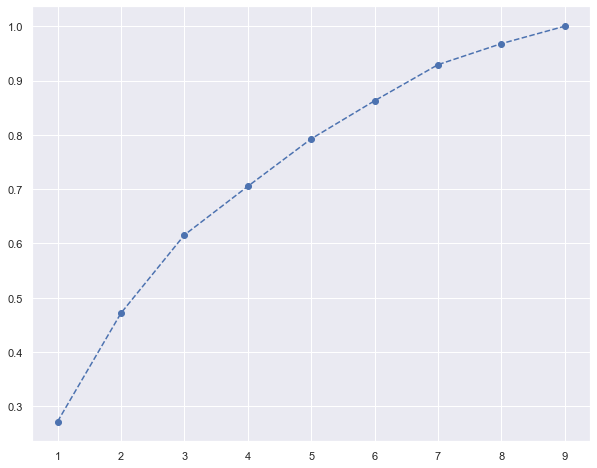

In [81]:
plt.figure(figsize = (10,8))
plt.plot(range(1,10), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')


In [83]:
pca = PCA(n_components = 3)

In [84]:
pca.fit(segmentation_std)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.transform(segmentation_std)

In [86]:
scores_pca = pca.transform(segmentation_std)

In [ ]:
scores_pca

In [88]:
from sklearn.cluster import KMeans

In [89]:
wcss = []
for i in range(1,5):
    kmeans_pca =KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)
    
    
    
    

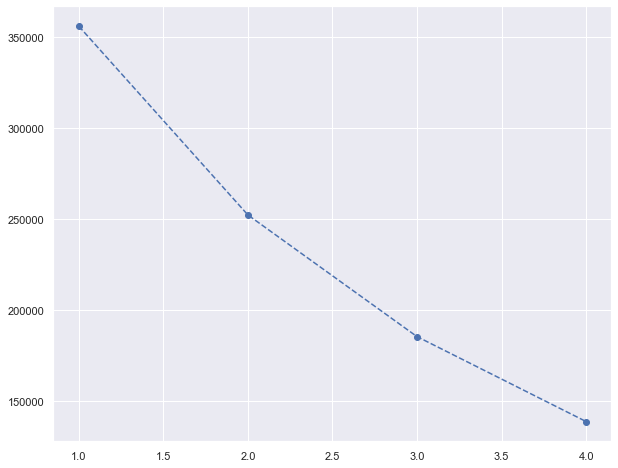

In [90]:
plt.figure(figsize = (10,8))
plt.plot(range(1,5), wcss, marker = 'o', linestyle = '--')
plt.show()

In [91]:
kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans_pca.fit(scores_pca)




KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [92]:
scores_pca

array([[ 4.381493  ,  0.2162164 ,  1.39573883],
       [-0.14842008, -0.9769023 ,  0.67811524],
       [-0.65623982,  2.71672072,  2.44711463],
       ...,
       [-1.07427318,  0.05356136, -0.49168278],
       [-0.10115041, -0.0902973 , -0.79338091],
       [-0.27974363, -0.74839929, -0.72819637]])

In [ ]:
pca_df

# Visualisation

In [97]:
pca_df_kmeans = pd.concat([pca_df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
pca_df_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']

pca_df_kmeans['Segment'] = kmeans_pca.labels_




In [ ]:
pca_df_kmeans.head()

In [99]:
pca_vis = pca_df_kmeans.copy([[]])
pca_vis = pca_df_kmeans[['Component 1', 'Component 2', 'Component 3', 'Segment']].copy()

In [100]:
# It's helpful to take a quick look at the count and
# average value values per cluster.

print('Cluster summary:')
summary = pca_df_kmeans.groupby(['Segment']).mean()
summary['count'] = pca_df_kmeans['Segment'].value_counts()
summary = summary.sort_values(by='count', ascending=False)
print(summary)


Cluster summary:
         freq_basic_exp  rec_basic_exp  mon_basic_exp  freq_disc_exp  \
Segment                                                                
0             30.849608       0.378402    2131.373721      43.198680   
2             11.154459       3.102088    1275.820038      17.360053   
1             28.510587       0.801886    2222.734206      41.976940   

         rec_disc_exp  mon_disc_exp  freq_lux_exp  rec_lux_exp  mon_lux_exp  \
Segment                                                                       
0            0.219296   4552.722221      0.136930    29.236009     3.095370   
2            1.638894   2694.412440      0.130654    28.919200     3.235156   
1            0.405144   4518.034997      2.176168    11.792542    99.945278   

         Component 1  Component 2  Component 3  count  
Segment                                                
0           0.175812    -0.995264    -0.102889  30753  
2          -1.452318     0.637583     0.185878  21844  
1 

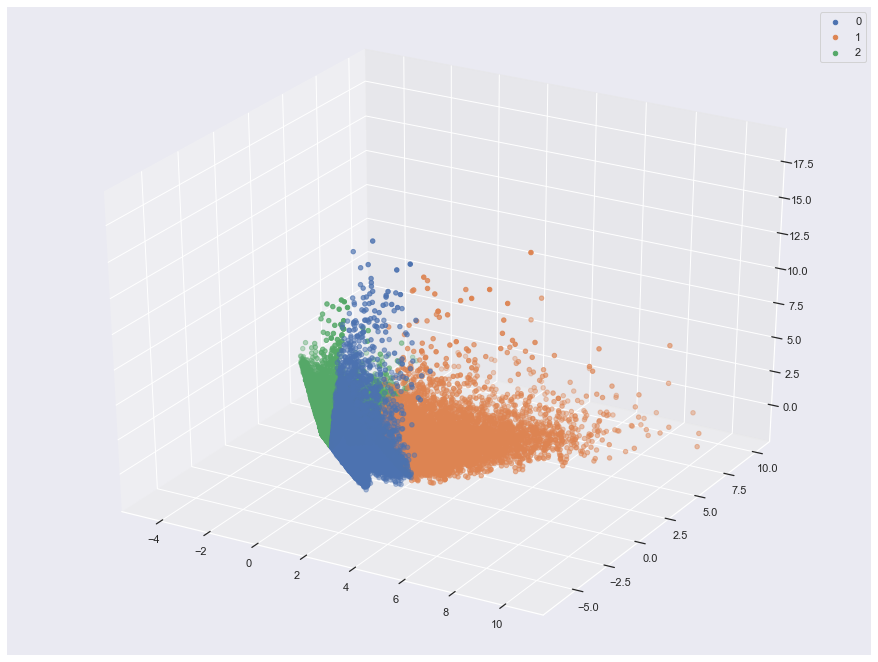

In [101]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

for grp_name, grp_idx in pca_vis.groupby('Segment').groups.items():
    y = pca_vis.iloc[grp_idx,1]
    x = pca_vis.iloc[grp_idx,0]
    z = pca_vis.iloc[grp_idx,2]
    ax.scatter(x,y,z, label=grp_name)  # this way you can control color/marker/size of each group freely
    
ax.legend()